In [1]:
import os
import warnings
import argparse
import datetime
import pathlib
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import pickle

from test import test
from utils.evaluate_uncertainty import evaluate_uncertainty
from core.config import create_config, save_config
# from core.dataset import COCODataset
# from core.dataset_hotswapped_flap import COCODataset
from core.dataset_hotswapped_blurred_context import COCODataset
from core.model import Model
from core.metrics import AccuracyLogger
import pickle
from SupContrast.losses import SupConLoss
import torch.nn.functional as F
import timm

In [2]:
# import importlib
# importlib.reload(core.dataset_hotswapped_blurred_context import COCODataset)

In [3]:
import core
from importlib import reload

In [4]:
reload(core.dataset_hotswapped_blurred_context)

<module 'core.dataset_hotswapped_blurred_context' from '/net/coxfs01/srv/export/coxfs01/pfister_lab2/share_root/Lab/spandan/contextual_domain_adaptation/WhenPigsFlyContext/core/dataset_hotswapped_blurred_context.py'>

In [5]:
from core.dataset_hotswapped_blurred_context import COCODataset

In [6]:
with open('../args_lift.p','rb') as F:
    args = pickle.load(F)

In [7]:
args.target_blur = False
args.blur_strength = 100
args.context_blur = False

In [8]:
# cfg = create_config(args)

In [9]:
# cfg.target_blur = args.target_blur

In [10]:
pathlib.Path(args.outdir).mkdir(exist_ok=True, parents=True)

# Load config or create a new one
cfg = create_config(args)

arbitrary_material_fols = sorted([i for i in os.listdir('../openrooms/') if 'arbitrary' in i])

if args.num_materials is not None and args.material_names is not None:
    print('Cannot provide both num_materials and material_names simultaneously, exiting')
    sys.exit()

if args.blur_strength is not None:
    cfg.blur_strength = args.blur_strength

if args.target_blur is not None:
    cfg.target_blur = args.target_blur

if args.context_blur is not None:
    cfg.context_blur = args.context_blur

if args.empty_baseline is not None:
    cfg.empty_baseline = args.empty_baseline

print('empty_baseline is')
print(cfg.empty_baseline)
if args.num_materials is not None:
    if args.num_materials== -1:
        new_materials = arbitrary_material_fols
    else:
        new_materials = arbitrary_material_fols[args.start_im:args.start_im + args.num_materials]

if args.material_names is not None:
    parts_string = args.material_names
    new_materials = parts_string.split(', ')

material_fols = new_materials
print('Using materials: %s'%material_fols)

dataset = COCODataset(cfg.annotations, cfg.imagedir, (224,224), material_fols, normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225],blur_strength=args.blur_strength, context_blur=args.context_blur, target_blur=args.target_blur)
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, num_workers=0, shuffle=True, pin_memory=True, drop_last=True)


empty_baseline is
False
Using materials: ['main_xml_50_2', 'main_xml_50_3', 'main_xml_50_4', 'main_xml_50_5']
Hotswapped material loader being used.
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12}
-------------------------------
Annotation Counts
-------------------------------
desk                       4829
trash_bin                  3204
chair                     19905
window                    10204
lamp                       2489
table                     11541
monitor                    3094
file_cabinet               1727
bookshelf                  3902
bed                        3214
sofa                       3550
bathtub                    1988
flowerpot                   227
Total                     69874
-------------------------------



In [11]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Taensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

In [12]:
for data in dataloader:
    break

In [13]:
import random
import matplotlib.pyplot as plt

In [23]:
%matplotlib inline

In [24]:
ID = random.choice(range(15))

# plt.imshow(unorm(data[0][ID]).permute(1,2,0))
# plt.show()

# plt.imshow(unorm(data[1][ID]).permute(1,2,0))
# plt.title(dataset.idx2label[data[5][ID].item()])
# plt.show()
# plt.show()

In [25]:
dat = unorm(data[0][ID]).permute(1,2,0)

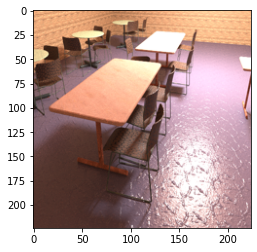

In [26]:
plt.imshow(dat)
plt.show()

In [38]:
empty_arr = torch.zeros(dat.shape)

In [40]:
imp

In [44]:
parts = []
for i in range(NUM):
    for j in range(NUM):
        SIZE = int(224/NUM)+1
        left_cut = SIZE*i
        right_cut = min(SIZE*(i+1),224)
        
        down_cut = SIZE*j
        up_cut = min(SIZE*(j+1),224)
        
        part = dat[left_cut:right_cut, down_cut:up_cut,:]
        parts.append(part)
    
parts.shuffle()
#         empty_a"rr[left_cut:right_cut, down_cut:up_cut,:] = part

AttributeError: 'list' object has no attribute 'shuffle'

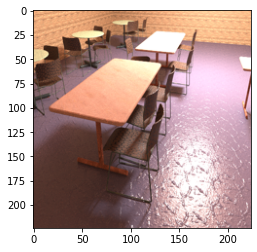

In [43]:
plt.imshow(empty_arr)
plt.show()

In [42]:
# NUM = 3
# parts = {}
# for i in range(NUM):
#     for j in range(NUM):
#         SIZE = int(224/NUM)+1
#         left_cut = SIZE*i
#         right_cut = min(SIZE*(i+1),224)
        
#         down_cut = SIZE*j
#         up_cut = min(SIZE*(j+1),224)
        
#         part = dat[left_cut:right_cut, down_cut:up_cut,:]
#         plt.imshow(part)
#         plt.show()

In [19]:
# import torchvision

In [20]:
# for ks in [5,25,45]:
#     blur_transform = torchvision.transforms.GaussianBlur(kernel_size=ks, sigma=(1*int(ks/3), 5*int(ks/3)))
#     transformed_data = blur_transform(data[1])
#     plt.imshow(transformed_data[ID].permute(1,2,0))
# #     plt.imshow(blur_transform(data[1][ID]).permute(1,2,0))
#     plt.title(ks)
# #     plt.title(dataset.idx2label[data[5][ID].item()])
#     plt.show()
#     plt.show()